<h1>10次元の変数にて因果推論</h1>
10次元、交互作用項ありで因果推論

In [221]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch import optim
import pyro
import pyro.distributions as dist

from tensorboardX import SummaryWriter

from tqdm import tqdm
import time


import numpy as np
import random
from numpy.random import *
import matplotlib.pyplot as plt 
#np.random.seed(100)
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

import csv

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

seed = 1234
rng = np.random.RandomState(seed)
torch.manual_seed(seed)

if torch.cuda.is_available():
    device='cuda'
else:
    device='cpu'

In [222]:
size = 70000
treat = np.random.binomial(1,0.5,size=size)
effect = 1.5
beta2 = 0.8
beta3 = 0.3
beta4 = 0.5

beta5 = 0.4
beta6 = 0.3
beta7 = 0.5
beta8 = 0.3
beta9 = 0.2
beta10 = 0.2

eps = 1e-10
#b = np.random.normal(3,0.2)
b = 0
def mkdata(x1=treat,effect=effect,beta2=beta2,beta3=beta3, beta4=beta4,beta5=beta5,beta6=beta6,beta7=beta7,beta8=beta8,\
          beta9=beta9,beta10=beta10, b=b,size=size):
    #x1 = np.random.binomial(1,0.5,size=size)
    x2 = np.random.normal(1.4*x1+0.4,2.0,size=size)
    x3 = np.random.normal(-0.8*x1+1.3*x2,0.5,size=size)
    x4 = np.random.normal(0.2*x1+-0.9*x2+2.3*x3,0.4,size=size)
    
    x5 = np.random.normal(0.4*x1+0.4,2.0,size=size)
    x6 = np.random.normal(-0.3*x1+1.5*x5+0.2,2.5,size=size)
    x7 = np.random.normal(0.2*x1+1.5*x5-1.4*x6,1.4,size=size)
    x8 = np.random.normal(1.0*x1+2.3*x7+1.2*x5,2.0,size=size)
    x9 = np.random.normal(-0.8*x1+0.4*x6+0.6*x2,1.5,size=size)
    x10 = np.random.normal(0.2*x1+0.5,1.4,size=size)
    
    yogo= effect*x1+beta2*x2+beta3*x3+beta4*x4+beta5*x5+beta6*x6+beta7*x7+beta8*x8+beta9*x9+beta10*x10+b
    return(np.array((x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,yogo)).T)

data = mkdata(x1=treat,size=size)
train_data = np.array(data[:60000])#train[:,0]:conditional, train[:,1]:feature, train[:,2]:outcome
test_data  = np.array(data[60000:])

In [223]:
import pandas as pd
trainpd=pd.DataFrame(train_data)
#trainpd
trainpd.head()

,0,1,2,3,4,5,6,7,8,9,10
0,1.0,4.508835,5.639292,9.170476,1.265946,0.727977,1.359337,1.182174,2.878188,2.026998,14.124223
1,0.0,3.803013,5.691587,9.919237,0.073731,0.383734,0.310176,-2.297011,5.049205,0.687027,10.467349
2,0.0,-1.912092,-2.264631,-4.107689,-1.040180,1.452625,-0.609208,-2.693683,-0.751741,1.398874,-5.226475
3,1.0,0.782060,-0.025199,-0.683092,4.038402,6.500664,-1.679990,-0.475820,2.644934,1.217951,5.131938
4,1.0,3.279651,3.258538,5.279770,0.441341,0.694285,-0.321526,-0.854369,2.425175,-0.737419,8.046466


4.750726926450496

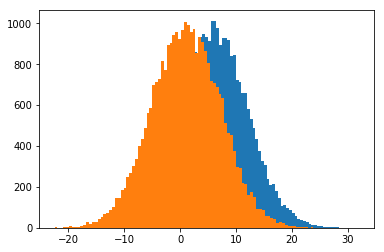

In [224]:
plt.hist(trainpd[(trainpd[0]==1)][10],bins=100)
plt.hist(trainpd[(trainpd[0]==0)][10],bins=100)
np.array(trainpd[(trainpd[0]==1)][10]).mean()-np.array(trainpd[(trainpd[0]==0)][10]).mean()

In [225]:
batch_size = 100
num_iters = 24000
num_epochs = int(batch_size* num_iters/len(train_data))

In [226]:
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size = batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size = batch_size, shuffle = False)

In [227]:
from pixyz.distributions import Bernoulli, Normal
from pixyz.losses import KullbackLeibler
from pixyz.models import VAE

In [228]:
class Inference(Normal):
    def __init__(self, input_dim,cond_dim, hidden_dim, latent_dim):
        super(Inference, self).__init__(cond_var=["x"], var=["z"], name="q")
        
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc31 = nn.Linear(hidden_dim, latent_dim)
        self.fc32 = nn.Linear(hidden_dim, latent_dim)
    def forward(self,x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        h = F.relu(self.fc3(h))
        return {"loc": self.fc31(h), "scale": F.softplus(self.fc32(h))}

class Generator(Normal):
    def __init__(self, latent_dim,cond_dim, hidden_dim, output_dim):
        super(Generator, self).__init__(cond_var=["z"], var=["x"], name="p")
        
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc31 = nn.Linear(hidden_dim, output_dim)
        self.fc32 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self,z):
        h = F.relu(self.fc1(z))
        h = F.relu(self.fc2(h))
        h = F.relu(self.fc3(h))
        return {"loc": self.fc31(h), "scale": F.softplus(self.fc32(h))}


In [229]:
input_dim = len(data[0])-2
hidden_dim = 100
latent_dim = 3
output_dim = input_dim
cond_dim = 2
estimate_dim =1

In [230]:
input_dim

9

In [231]:
p = Generator(latent_dim,cond_dim, hidden_dim, output_dim)
q = Inference(input_dim,cond_dim, hidden_dim, latent_dim)


p.to(device)
q.to(device)


Inference(
  (fc1): Linear(in_features=9, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=100, bias=True)
  (fc31): Linear(in_features=100, out_features=3, bias=True)
  (fc32): Linear(in_features=100, out_features=3, bias=True)
)

In [232]:
loc = torch.tensor(0.)
scale = torch.tensor(1.)
prior = Normal(loc=loc, scale=scale, var=["z"], dim= latent_dim, name="p_prior")

In [233]:
kl = KullbackLeibler(q,prior)

In [234]:
model = VAE(q,p, regularizer = kl, optimizer=optim.Adam, optimizer_params={"lr":1e-4})

In [235]:
def input_shaper(x,input_dim):
    return x.view(-1, input_dim).float()
    
def tag_shaper(tag):
    return torch.eye(2)[tag.long()].float()



def train(epoch, input_dim):
    train_loss = 0
    for _data in tqdm(train_loader):
        x = input_shaper(_data[:, 1:input_dim+1],input_dim)
        
        x = x.to(device)
        loss = model.train({"x":x})
        train_loss += loss
    
    #pytorchのlossはデフォルトでは平均の値になる。このためバッチ長をかけて
    #全体で割って全体のlossを計算する
    
    train_loss = train_loss * train_loader.batch_size / len(train_loader.dataset)
    print('Epoch:{} Train loss:{:.4f}'.format(epoch, train_loss))
    return train_loss

In [236]:
data[:, 1:input_dim+1]

array([[  4.50883462,   5.63929157,   9.17047629, ...,   1.18217391,
          2.87818782,   2.02699819],
       [  3.80301328,   5.69158667,   9.9192374 , ...,  -2.29701074,
          5.04920462,   0.68702725],
       [ -1.91209183,  -2.26463101,  -4.10768914, ...,  -2.69368319,
         -0.75174133,   1.39887369],
       ...,
       [ -1.02353814,  -3.35793573,  -6.86806087, ...,  10.20485864,
         -2.89465413,  -0.59976379],
       [  0.01637355,  -0.51182831,  -0.88159814, ..., -11.57425986,
          1.53553838,  -0.82904276],
       [ -0.21573942,   0.17721776,   1.04540058, ...,  11.46602442,
          1.39461802,  -0.01559311]])

In [237]:
def test(epoch, input_dim):
    test_loss = 0
    for _data in test_loader:

        x = input_shaper(_data[:, 1:input_dim+1],input_dim)
        x = x.to(device)

        
        loss = model.test({"x":x})
        test_loss += loss
    test_loss = test_loss * test_loader.batch_size/ len(test_loader.dataset)
    print('Test loss:{:.4f}'.format(test_loss))
    return test_loss

In [238]:
def plot_reconstrunction(x,y,output_dim):
    with torch.no_grad():
        z = q.sample({"x":x}, return_all=False)
        #z.update({"y":y})
        recon_batch = p.sample_mean(z).view(-1, output_dim)
        recon = torch.cat([x.view(-1, output_dim), recon_batch]).cpu()
        return recon

def plot_image_from_latent(z,y, output_dim):
    with torch.no_grad():
        sample = p.sample_mean({"z":z, "y":y}).view(-1, output_dim).cpu()
        return sample

def plot_reconstraction_changing_y(x,y, output_dim):
    y_change = torch.eye(2)[range(2)].to(device)
    batch_dummy = torch.ones(x.size(0))[:, None].to(device)
    recon_all = []
    
    with torch.no_grad():
        for _y in y_change:
            z = q.sample({"x": x, "y": y}, return_all=False)   #batch数だけx,yを代入
            z.update({"y": batch_dummy * _y[None,:]})
            
            recon_batch = p.sample_mean(z).view(-1, output_dim)
            recon_all.append(recon_batch)
            
        recon_changing_y = torch.cat(recon_all)
        recon_changing_y = torch.cat([x.view( -1, output_dim), recon_changing_y]).cpu()
        
        return recon_changing_y

In [239]:
writer = SummaryWriter()

plot_number = 1

z_sample = 0.5 * torch.randn(64, latent_dim).to(device)
y_sample = torch.eye(2)[[plot_number]*64].to(device)

_data = iter(test_loader).next()

_y = tag_shaper(_data[:,0])
_x = input_shaper(_data[:, 1:input_dim+1],input_dim)
_x = _x.to(device)
_y = _y.to(device)


for epoch in range(1, num_epochs + 1):
    train_loss = train(epoch, input_dim)
    test_loss = test(epoch, input_dim)
    
    recon = plot_reconstrunction(_x[:8], _y[:8], output_dim)
    #sample = plot_image_from_latent(z_sample, y_sample, output_dim)
    #recon_changing_y = plot_reconstraction_changing_y(_x[:8], _y[:8], output_dim)
    

    writer.add_scalar('train_loss', train_loss.item(), epoch)
    writer.add_scalar('test_loss', test_loss.item(), epoch)      
    """
    writer.add_image('Image_from_latent', sample, epoch)
    writer.add_image('Image_reconstrunction', recon, epoch)
    writer.add_image('Image_reconstrunction_change_y', recon_changing_y, epoch)
    """
writer.close()

  0%|          | 0/600 [00:00<?, ?it/s]

Epoch:1 Train loss:43.4455
Test loss:23.9104


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch:2 Train loss:23.2794
Test loss:23.0053


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch:3 Train loss:22.7769
Test loss:22.7549


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch:4 Train loss:22.5091
Test loss:22.1063


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch:5 Train loss:20.5318
Test loss:19.8106


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch:6 Train loss:19.6329
Test loss:19.5592


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch:7 Train loss:19.4716
Test loss:19.4280


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch:8 Train loss:19.4000
Test loss:19.3623


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch:9 Train loss:19.3418
Test loss:19.3507


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch:10 Train loss:19.3004
Test loss:19.3485


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch:11 Train loss:19.2800
Test loss:19.2763


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch:12 Train loss:19.2641
Test loss:19.2741


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch:13 Train loss:19.2213
Test loss:19.2219


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch:14 Train loss:19.1351
Test loss:18.9748


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch:15 Train loss:18.5704
Test loss:18.2646


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch:16 Train loss:18.1259
Test loss:18.0401


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch:17 Train loss:17.9595
Test loss:17.9482


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch:18 Train loss:17.8967
Test loss:17.9095


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch:19 Train loss:17.8528
Test loss:17.8752


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch:20 Train loss:17.8387
Test loss:17.8108


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch:21 Train loss:17.8160
Test loss:17.8101


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch:22 Train loss:17.7972
Test loss:17.8478


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch:23 Train loss:17.7921
Test loss:17.7844


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch:24 Train loss:17.7847
Test loss:17.7606


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch:25 Train loss:17.7698
Test loss:17.8074


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch:26 Train loss:17.7693
Test loss:17.8241


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch:27 Train loss:17.7597
Test loss:17.7436


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch:28 Train loss:17.7414
Test loss:17.7775


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch:29 Train loss:17.7375
Test loss:17.7465


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch:30 Train loss:17.7354
Test loss:17.6878


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch:31 Train loss:17.7072
Test loss:17.7538


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch:32 Train loss:17.7214
Test loss:17.7221


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch:33 Train loss:17.7039
Test loss:17.6716


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch:34 Train loss:17.7015
Test loss:17.7265


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch:35 Train loss:17.6783
Test loss:17.6982


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch:36 Train loss:17.6642
Test loss:17.7663


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch:37 Train loss:17.5095
Test loss:16.9878


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch:38 Train loss:16.4690
Test loss:16.3127


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch:39 Train loss:16.2356
Test loss:16.1586


100%|██████████| 600/600 [00:04<00:00, 143.94it/s]


Epoch:40 Train loss:16.1851
Test loss:16.2359


In [258]:
input_dim+1

10

In [259]:
data[:, 1:input_dim+1]

array([[  4.50883462,   5.63929157,   9.17047629, ...,   1.18217391,
          2.87818782,   2.02699819],
       [  3.80301328,   5.69158667,   9.9192374 , ...,  -2.29701074,
          5.04920462,   0.68702725],
       [ -1.91209183,  -2.26463101,  -4.10768914, ...,  -2.69368319,
         -0.75174133,   1.39887369],
       ...,
       [ -1.02353814,  -3.35793573,  -6.86806087, ...,  10.20485864,
         -2.89465413,  -0.59976379],
       [  0.01637355,  -0.51182831,  -0.88159814, ..., -11.57425986,
          1.53553838,  -0.82904276],
       [ -0.21573942,   0.17721776,   1.04540058, ...,  11.46602442,
          1.39461802,  -0.01559311]])

In [260]:
temp_data=np.array(data[:, 1:input_dim+1])
z=q.sample({"x":input_shaper(_data[:, 1:input_dim+1],input_dim).to(device)}, return_all=False)
x_hat=p.sample({"z":z.get("z")}, return_all=False)
x_out=x_hat.get("x").cpu()
x_in = _data[:, 1:input_dim+1]

(array([ 2.,  2., 13., 23., 13., 15., 20.,  7.,  3.,  2.]),
 array([-5.36748  , -4.1770434, -2.9866068, -1.7961705, -0.605734 ,
         0.5847025,  1.775139 ,  2.9655755,  4.156012 ,  5.3464484,
         6.536885 ], dtype=float32),
 <a list of 10 Patch objects>)

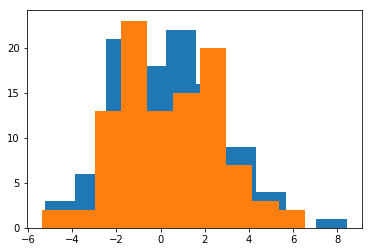

In [261]:
plt.hist(x_in[:,0],bins=10)
plt.hist(x_out[:,0],bins=10)

(array([ 3.,  3., 19., 15., 21., 20., 11.,  5.,  2.,  1.]),
 array([-7.30147  , -5.6030855, -3.904701 , -2.2063167, -0.5079323,
         1.1904521,  2.8888364,  4.5872207,  6.2856054,  7.9839897,
         9.682374 ], dtype=float32),
 <a list of 10 Patch objects>)

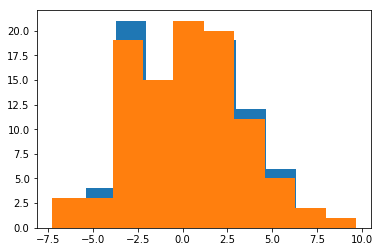

In [262]:
plt.hist(x_in[:,1])
plt.hist(x_out[:,1])

(array([ 3.,  5., 17., 14., 22., 20., 10.,  4.,  4.,  1.]),
 array([-11.408149 ,  -8.832111 ,  -6.2560735,  -3.6800356,  -1.103998 ,
          1.4720397,   4.0480776,   6.624115 ,   9.200152 ,  11.776191 ,
         14.352228 ], dtype=float32),
 <a list of 10 Patch objects>)

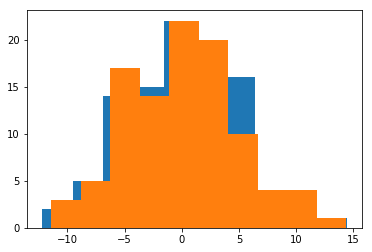

In [263]:
plt.hist(x_in[:,2])
plt.hist(x_out[:,2])

(array([ 2.,  2.,  8., 10., 19., 25., 11., 18.,  3.,  2.]),
 array([-6.899007  , -5.471721  , -4.044435  , -2.6171494 , -1.1898636 ,
         0.23742223,  1.664708  ,  3.0919938 ,  4.5192795 ,  5.9465656 ,
         7.3738513 ], dtype=float32),
 <a list of 10 Patch objects>)

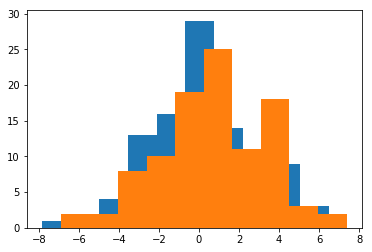

In [264]:
plt.hist(x_in[:,7])
plt.hist(x_out[:,7])

In [265]:
(x_in.float()-x_out.float()).mean(dim=0)

tensor([ 0.0630,  0.0120,  0.0318, -0.0561, -0.0761, -0.1323, -0.3001, -0.4852,
         0.1044])

In [266]:
class Estimator(nn.Module):
    def __init__(self, cond_dim, hidden_dim, latent_dim, estimate_dim):
        super(Estimator, self).__init__()
        
        self.fc1 = nn.Linear(latent_dim+cond_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, estimate_dim)
        
    def forward(self,z,y):
        h = F.relu(self.fc1(torch.cat([z,y],1)))
        h = F.relu(self.fc2(h))
        return self.fc3(h)

criterion = nn.MSELoss()
model2 = Estimator(cond_dim, hidden_dim, latent_dim, estimate_dim)
model2.to(device)
optimizer = torch.optim.SGD(model2.parameters(),lr=1e-3)

In [286]:
for epoch in range(1, 15):
    for _data in tqdm(train_loader):
        y = tag_shaper(_data[:,0])
        x = input_shaper(_data[:, 1:input_dim+1],input_dim)
        o = input_shaper(_data[:, input_dim+1],estimate_dim)
        x = x.to(device)
        y = y.to(device)
        o = o.to(device)
        
        optimizer.zero_grad()
        
        z = q.sample({"x":x}, return_all=False)
        latent = z.get('z')
        output = model2(latent,y)
        loss = criterion(output,o)        
        loss.backward()
        
        optimizer.step()
    
    total = 0
    total_loss = 0
    for _data in test_loader:
        y = tag_shaper(_data[:,0])
        x = input_shaper(_data[:, 1:input_dim+1],input_dim)
        o = input_shaper(_data[:, input_dim+1],estimate_dim)
        x = x.to(device)
        y = y.to(device)
        o = o.to(device)
        
        z = q.sample({"x":x}, return_all=False)
        latent = z.get('z')
        output = model2(latent,y)
        loss = criterion(output,o)
        
        total_loss += loss *len(_data)
        total += len(_data)
    test_loss = total_loss/total
    
    print('Epochs:{}, train_Loss:{}, test_Loss:{:.2f}'.format(epoch,loss.item(), test_loss.item()))

  8%|▊         | 47/600 [00:00<00:01, 464.17it/s]

Epochs:1, train_Loss:0.588973343372345, test_Loss:0.73


  8%|▊         | 49/600 [00:00<00:01, 485.89it/s]

Epochs:2, train_Loss:0.7863340973854065, test_Loss:0.74


  8%|▊         | 46/600 [00:00<00:01, 454.04it/s]

Epochs:3, train_Loss:0.6382278203964233, test_Loss:0.73


  8%|▊         | 48/600 [00:00<00:01, 475.08it/s]

Epochs:4, train_Loss:0.8159379363059998, test_Loss:0.74


  8%|▊         | 47/600 [00:00<00:01, 460.57it/s]

Epochs:5, train_Loss:0.7029598951339722, test_Loss:0.73


 10%|▉         | 57/600 [00:00<00:00, 563.08it/s]

Epochs:6, train_Loss:0.6521168351173401, test_Loss:0.73


 10%|▉         | 57/600 [00:00<00:00, 568.14it/s]

Epochs:7, train_Loss:0.7214199304580688, test_Loss:0.73


 10%|▉         | 57/600 [00:00<00:00, 568.77it/s]

Epochs:8, train_Loss:0.8049842119216919, test_Loss:0.72


  8%|▊         | 46/600 [00:00<00:01, 454.78it/s]

Epochs:9, train_Loss:0.8148362636566162, test_Loss:0.72


  8%|▊         | 47/600 [00:00<00:01, 467.68it/s]

Epochs:10, train_Loss:0.7718881964683533, test_Loss:0.73


  7%|▋         | 44/600 [00:00<00:01, 437.45it/s]

Epochs:11, train_Loss:0.6477125287055969, test_Loss:0.74


  8%|▊         | 46/600 [00:00<00:01, 457.17it/s]

Epochs:12, train_Loss:0.7621991634368896, test_Loss:0.73


 10%|▉         | 57/600 [00:00<00:00, 561.85it/s]

Epochs:13, train_Loss:0.7026353478431702, test_Loss:0.74


100%|██████████| 600/600 [00:01<00:00, 574.42it/s]


Epochs:14, train_Loss:0.8199538588523865, test_Loss:0.73


In [309]:
pt_size = 10000
z_sample = 0.3* torch.randn(pt_size, latent_dim).to(device)

# 非治療群を生成
plot_number = 0
uy_sample = torch.eye(2)[[plot_number]*pt_size].to(device)
untreated=model2(z_sample,uy_sample)

# 治療群を生成
plot_number = 1
ty_sample = torch.eye(2)[[plot_number]*pt_size].to(device)
treated=model2(z_sample,ty_sample)

(array([  1.,   1.,   0.,   0.,   0.,   1.,   1.,   0.,   2.,   2.,   2.,
          1.,   2.,   1.,   3.,   5.,   4.,   9.,   9.,   9.,  12.,  18.,
         13.,  26.,  24.,  40.,  31.,  46.,  61.,  58.,  77.,  83.,  84.,
        100., 124., 113., 142., 157., 182., 200., 216., 210., 233., 263.,
        278., 267., 281., 320., 298., 356., 332., 364., 355., 339., 337.,
        345., 280., 292., 255., 286., 223., 262., 253., 248., 183., 164.,
        149., 127., 132.,  98., 113.,  88.,  79.,  47.,  46.,  40.,  38.,
         28.,  33.,  17.,  22.,  11.,  12.,   5.,   8.,   5.,   4.,   4.,
          3.,   1.,   2.,   1.,   0.,   0.,   2.,   0.,   0.,   0.,   0.,
          1.]),
 array([-4.851593  , -4.704221  , -4.5568485 , -4.4094763 , -4.2621045 ,
        -4.1147323 , -3.96736   , -3.8199878 , -3.6726158 , -3.5252435 ,
        -3.3778713 , -3.2304993 , -3.083127  , -2.9357548 , -2.7883825 ,
        -2.6410105 , -2.4936383 , -2.346266  , -2.198894  , -2.0515218 ,
        -1.9041497 , -1.75

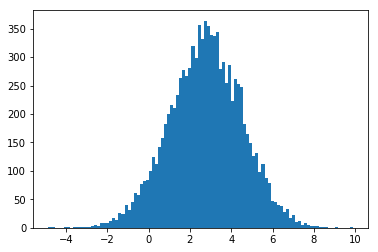

In [310]:
plt.hist(untreated.detach().cpu().numpy(),bins=100)

(array([  1.,   0.,   1.,   0.,   0.,   0.,   2.,   0.,   2.,   0.,   4.,
          1.,   2.,   1.,   1.,   5.,   2.,   7.,  12.,   7.,   9.,  18.,
         12.,  22.,  21.,  42.,  34.,  44.,  52.,  57.,  70.,  88.,  83.,
         98., 108., 107., 134., 156., 182., 211., 205., 244., 236., 251.,
        283., 278., 277., 316., 294., 362., 315., 326., 354., 312., 336.,
        341., 293., 291., 285., 267., 235., 252., 234., 258., 197., 159.,
        169., 123., 127., 121., 104., 103.,  82.,  71.,  48.,  41.,  42.,
         29.,  35.,  21.,  18.,  16.,  12.,   7.,   8.,   6.,   5.,   2.,
          6.,   1.,   1.,   2.,   0.,   0.,   2.,   0.,   0.,   0.,   0.,
          1.]),
 array([-3.1903186 , -3.040875  , -2.891431  , -2.7419872 , -2.5925436 ,
        -2.4431    , -2.293656  , -2.1442122 , -1.9947686 , -1.8453249 ,
        -1.6958811 , -1.5464374 , -1.3969936 , -1.2475499 , -1.0981061 ,
        -0.9486624 , -0.79921865, -0.6497749 , -0.50033116, -0.35088742,
        -0.20144367, -0.05

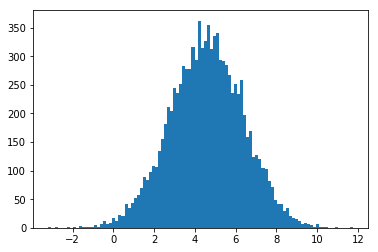

In [311]:
plt.hist(treated.detach().cpu().numpy(),bins=100)

1.8105102

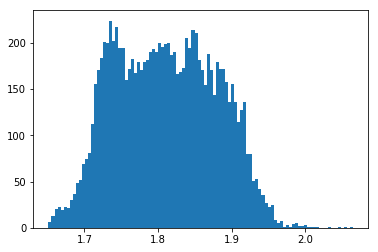

In [312]:
plt.hist(treated.detach().cpu().numpy()-untreated.detach().cpu().numpy(),bins=100)
(treated.detach().cpu().numpy()-untreated.detach().cpu().numpy()).mean()

In [320]:
uy_sample

tensor([[1., 0.],
        [1., 0.],
        [1., 0.],
        ...,
        [1., 0.],
        [1., 0.],
        [1., 0.]], device='cuda:0')

(array([2.000e+00, 1.000e+00, 0.000e+00, 2.000e+00, 2.000e+00, 7.000e+00,
        4.000e+00, 3.000e+00, 3.000e+00, 1.100e+01, 1.200e+01, 2.700e+01,
        1.800e+01, 2.700e+01, 2.600e+01, 4.100e+01, 5.500e+01, 6.800e+01,
        7.200e+01, 8.600e+01, 1.020e+02, 1.440e+02, 1.480e+02, 1.870e+02,
        1.930e+02, 2.490e+02, 2.660e+02, 3.000e+02, 3.380e+02, 4.010e+02,
        4.330e+02, 4.870e+02, 5.630e+02, 5.850e+02, 6.970e+02, 7.130e+02,
        7.260e+02, 8.160e+02, 7.730e+02, 8.920e+02, 9.020e+02, 9.420e+02,
        9.580e+02, 9.230e+02, 9.680e+02, 1.009e+03, 9.930e+02, 9.560e+02,
        9.740e+02, 8.530e+02, 9.350e+02, 9.110e+02, 8.660e+02, 8.080e+02,
        7.170e+02, 7.090e+02, 6.910e+02, 6.550e+02, 6.340e+02, 5.150e+02,
        4.640e+02, 4.560e+02, 3.750e+02, 2.960e+02, 2.920e+02, 2.200e+02,
        2.120e+02, 1.620e+02, 1.760e+02, 1.490e+02, 9.000e+01, 9.400e+01,
        8.700e+01, 5.600e+01, 5.900e+01, 5.000e+01, 4.200e+01, 2.500e+01,
        2.900e+01, 2.300e+01, 1.600e+0

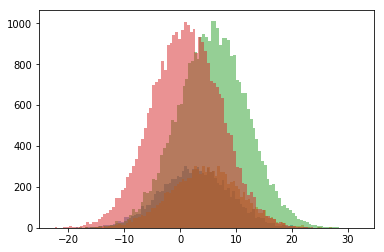

In [308]:
plt.hist(untreated,bins=100,alpha=0.5)
plt.hist(treated,bins=100,alpha=0.5)

plt.hist(trainpd[(trainpd[0]==1)][10],bins=100,alpha=0.5)
plt.hist(trainpd[(trainpd[0]==0)][10],bins=100,alpha=0.5)

(array([  3.,   0.,   3.,   0.,   3.,   5.,   4.,  14.,  12.,   7.,   9.,
         18.,  12.,  27.,  29.,  33.,  42.,  40.,  44.,  64.,  72., 104.,
        111., 138., 167., 160., 224., 278., 288., 291., 316., 387., 407.,
        433., 471., 557., 563., 653., 623., 685., 733., 721., 792., 864.,
        842., 904., 827., 914., 867., 886., 903., 870., 887., 883., 853.,
        772., 802., 718., 661., 660., 640., 614., 555., 506., 490., 404.,
        354., 335., 309., 287., 243., 206., 164., 175., 173., 104., 115.,
         74.,  83.,  65.,  46.,  36.,  27.,  28.,  25.,  18.,  19.,  20.,
          6.,   6.,   9.,   6.,   6.,   4.,   2.,   1.,   2.,   1.,   2.,
          1.]),
 array([-7.08557848, -6.93332974, -6.78108101, -6.62883228, -6.47658355,
        -6.32433482, -6.17208609, -6.01983735, -5.86758862, -5.71533989,
        -5.56309116, -5.41084243, -5.2585937 , -5.10634497, -4.95409623,
        -4.8018475 , -4.64959877, -4.49735004, -4.34510131, -4.19285258,
        -4.04060384, -3.88

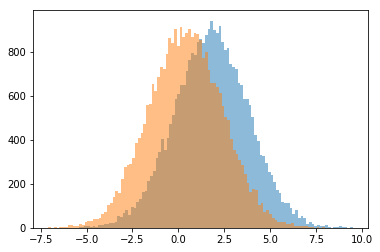

In [307]:
plt.hist(trainpd[(trainpd[0]==1)][1],bins=100,alpha=0.5)
plt.hist(trainpd[(trainpd[0]==0)][1],bins=100,alpha=0.5)